# SVMの実装

「ゼロからつくるPython機械学習プログラミング入門」(八谷大岳)を参考に作成した。特にSVMの実装部分は大きく元にしている。

In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import cvxopt
from cvxopt import matrix
import matplotlib.pylab as plt
import data
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

In [25]:
class SVM():
    # 1. 学習データの初期化
    def __init__(self,X,Y):

        # 学習データの設定
        self.X = X
        self.Y = Y
        #print(Y.shape)
        self.dnum = X.shape[0]  # 学習データ数
        self.xdim = X.shape[1]  # 入力の次元数
        
        # サポートベクトルの閾値設定
        self.spptvecThre = 0.1

    # 2. SVMのモデルパラメータを最適化
    def train(self):

        # 行列Pの作成
        P = np.matmul(self.Y,self.Y.T) * np.matmul(self.X,self.X.T)
        P = cvxopt.matrix(P)

        # q,L,m,A,bを作成
        q = cvxopt.matrix(-np.ones(self.dnum))
        L = cvxopt.matrix(np.diag(-np.ones(self.dnum)))
        m = cvxopt.matrix(np.zeros(self.dnum))
        A = cvxopt.matrix(self.Y.astype(float).T)
        #A = matrix(A,(1, self.Y.shape[0]),'d')
        b = cvxopt.matrix(0.0)

        # 凸二次計画法
        sol = cvxopt.solvers.qp(P,q,L,m,A,b)
        self.lamb = np.array(sol['x'])
        # 'x'がlambdaに対応する
        
        # サポートベクトルのインデックス
        self.spptInds = np.where(self.lamb>self.spptvecThre)[0]

        # wとbの計算
        self.w = np.matmul((self.lamb*self.Y).T,self.X).T
        self.b = np.mean(self.Y[self.spptInds]-np.matmul(self.X[self.spptInds,:],self.w))

    # 2.5 ソフトマージンSVMのモデルパラメータを最適化
    # C: 誤差の重要度ハイパーパラメータ（スカラー、デフォルトでは0.1）
    def train_soft(self,C=0.1):
        X = self.X
        
        # 行列Pの作成
        P = np.matmul(self.Y,self.Y.T) * np.matmul(X,X.T)
        P = cvxopt.matrix(P)
        
        # q,L,m,A,bを作成
        q = cvxopt.matrix(-np.ones(self.dnum))
        L1 = np.diag(-np.ones(self.dnum))
        L2 = np.diag(np.ones(self.dnum))
        L = cvxopt.matrix(np.concatenate([L1,L2],axis=0))
        m1 = np.zeros([self.dnum,1])
        m2 = C * np.ones([self.dnum,1])
        m = cvxopt.matrix(np.concatenate([m1,m2],axis=0))
        A = cvxopt.matrix(self.Y.astype(float).T)
        #A = A.astype(double)
        b = cvxopt.matrix(0.0)

        # 凸二次計画法
        sol = cvxopt.solvers.qp(P,q,L,m,A,b)
        self.lamb = np.array(sol['x'])
        # 'x'がlambdaに対応する
        
        # サポートベクトルのインデックス
        self.spptInds = np.where(self.lamb>self.spptvecThre)[0]
        
        # wとbの計算
        self.w = np.matmul((self.lamb*self.Y).T,X).T
        self.b = np.mean(self.Y[self.spptInds]-np.matmul(X[self.spptInds,:],self.w))

    # 3. 予測
    # X: 入力データ（データ数×次元数のnumpy.ndarray）
    def predict(self,x):
        y = np.matmul(x,self.w) + self.b
        return np.sign(y),y

    # 4. 正解率の計算
    # X: 入力データ（データ数×次元数のnumpy.ndarray）
    # Y: 出力データ（データ数×１のnumpy.ndarray）
    def accuracy(self,X,Y):
        predict,_ = self.predict(X)
        return np.sum(predict==Y)/len(X)
    #-------------------

    #-------------------
    # 5. 真値と予測値のプロット（入力ベクトルが2次元の場合）
    # X:入力データ（データ数×次元数のnumpy.ndarray）
    # Y:出力データ（データ数×１のnumpy.ndarray）
    # spptInds:サポートベクトルのインデックス（インデックス数のnumpy.ndarray)
    # xLabel:x軸のラベル（文字列）
    # yLabel:y軸のラベル（文字列）
    # title:タイトル（文字列）
    # fName：画像の保存先（文字列）
    # isLinePlot：分類境界の直線をプロットするかしないか（boolean)
    def plotModel2D(self,X=[],Y=[],spptInds=[],xLabel="",yLabel="",title="",fName="",isLinePlot=False):
        plt.close()
        
        # 真値のプロット（クラスごとにマーカーを変更）
        plt.plot(X[Y[:,0]==-1,0],X[Y[:,0]==-1,1],'cx',markerSize=14,label="category-1")
        plt.plot(X[Y[:,0]== 1,0],X[Y[:,0]== 1,1],'m.',markerSize=14,label="category+1")

        # 予測値のメッシュの計算
        X1,X2 = plt.meshgrid(plt.linspace(np.min(X[:,0]),np.max(X[:,0]),50),plt.linspace(np.min(X[:,1]),np.max(X[:,1]),50))
        Xmesh = np.hstack([np.reshape(X1,[-1,1]),np.reshape(X2,[-1,1])])
        _,Ymesh = self.predict(Xmesh)
        Ymesh = np.reshape(Ymesh,X1.shape)

        # contourプロット
        CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)

        # カラーバー
        CB = plt.colorbar(CS)
        CB.ax.tick_params(labelsize=14)
        
        # サポートベクトルのプロット
        if len(spptInds):
            plt.plot(X[spptInds,0],X[spptInds,1],'o',color='none',markeredgecolor='r',markersize=18,markeredgewidth=3,label="support vector")

        # 直線のプロット
        if isLinePlot:
            x1 = np.arange(np.min(X[:,0]),np.max(X[:,0]),(np.max(X[:,0]) - np.min(X[:,0]))/100)
            x2 = -(x1*self.w[0]+self.b)/self.w[1]
            plt.plot(x1,x2,'r-',label="f(x)")

        # 各軸の範囲、タイトルおよびラベルの設定
        plt.xlim([np.min(X[:,0]),np.max(X[:,0])])
        plt.ylim([np.min(X[:,1]),np.max(X[:,1])])
        plt.title(title,fontSize=14)
        plt.xlabel(xLabel,fontSize=14)
        plt.ylabel(yLabel,fontSize=14)
        plt.legend()

        # グラフの表示またはファイルへの保存
        if len(fName):
            plt.savefig(fName)
        else:
            plt.show()
    #-------------------

### 実行
データタイプを選べるようにしている  
ソフトマージンを用いるかどうかをTrue, Falseで決められるようにしている

In [26]:
def calculate(dataType, train_soft=False):
    # 1. データの作成
    myData = data.classification(negLabel=-1.0,posLabel=1.0)
    myData.makeData(dataType)

    # 2. データを学習と評価用に分割
    dtrNum = int(len(myData.X)*0.9)  # 学習データ数
    # 学習データ（全体の90%）
    Xtr = myData.X[:dtrNum]
    Ytr = myData.Y[:dtrNum]

    # 評価データ（全体の10%）
    Xte = myData.X[dtrNum:]
    Yte = myData.Y[dtrNum:]

    # 3. 標準化
    xMean = np.mean(Xtr,axis=0)
    xStd = np.std(Xtr,axis=0)
    Xtr = (Xtr-xMean)/xStd
    Xte = (Xte-xMean)/xStd

    # 4. SVMのモデルの学習
    myModel = SVM(Xtr,Ytr)
    #myModel.train()
    if train_soft:
        myModel.train_soft(0.5)
    else:
        myModel.train()

    # 5. SVMモデルの評価
    print(f"モデルパラメータ:\nw={myModel.w}\nb={myModel.b}")
    print(f"評価データの正解率={myModel.accuracy(Xte,Yte):.5f}")

    # 6. 真値と予測値のプロット
    myModel.plotModel2D(X=Xtr,Y=Ytr,spptInds=myModel.spptInds,xLabel=myData.xLabel,yLabel=myData.yLabel,
        title=f"learning accuracy:{myModel.accuracy(Xtr,Ytr):.2f},estimation accuracy:{myModel.accuracy(Xte,Yte):.5f}",
        fName=f"results/SVM_result_{myData.dataType}.pdf",
        isLinePlot=True)

     pcost       dcost       gap    pres   dres
 0: -9.6437e+00 -1.7171e+01  3e+02  2e+01  2e+00
 1: -1.0855e+01 -5.2476e+00  4e+01  2e+00  2e-01
 2: -4.3311e+00 -3.1928e+00  2e+00  2e-01  2e-02
 3: -3.1221e+00 -3.0956e+00  1e-01  7e-03  7e-04
 4: -3.0879e+00 -3.0875e+00  1e-03  8e-05  8e-06
 5: -3.0874e+00 -3.0874e+00  1e-05  8e-07  8e-08
 6: -3.0874e+00 -3.0874e+00  1e-07  8e-09  8e-10
Optimal solution found.
モデルパラメータ:
w=[[-1.68495789]
 [-1.82641906]]
b=0.06019019272615186
評価データの正解率=1.00000


<ipython-input-25-4dcc5c2c3303>:113: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


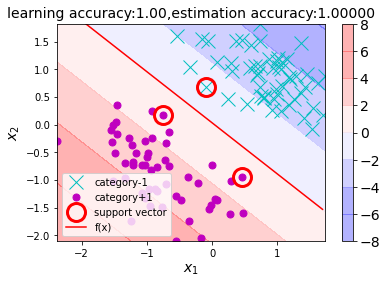

In [27]:
calculate(3)

(108, 1)
     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  1e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-15  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  4e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  3e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  8e-16
 6: -2.6144e+01 -2.6193e+01  5e-02  1e-15  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.
モデルパラメータ:
w=[[-1.37910576]
 [ 0.30693955]]
b=0.06456857211957005
評価データの正解率=0.83333


<ipython-input-16-f44fd2e4023e>:113: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


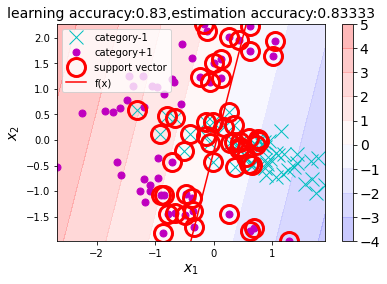

In [18]:
calculate(4, True)

(108, 1)
     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  2e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  3e-16  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  2e-15  9e-16
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-15  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  2e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  9e-16  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  4e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  2e-15  1e-15
Optimal solution found.
モデルパラメータ:
w=[[ 0.36839786]
 [-0.61014893]]
b=0.027893846547780106
評価データの正解率=0.66667


<ipython-input-16-f44fd2e4023e>:113: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


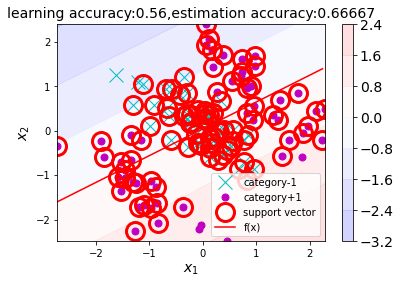

In [19]:
calculate(5, True)

(331, 1)
     pcost       dcost       gap    pres   dres
 0: -8.1406e+01 -5.2576e+02  7e+03  8e+00  9e-15
 1: -3.7713e+01 -4.3450e+02  1e+03  1e+00  7e-15
 2: -1.8985e+01 -2.0575e+02  3e+02  2e-01  8e-15
 3: -7.4043e+00 -3.8650e+01  4e+01  2e-02  1e-14
 4: -9.1275e+00 -1.8773e+01  1e+01  5e-03  4e-15
 5: -1.0009e+01 -1.5868e+01  7e+00  3e-03  2e-15
 6: -1.0633e+01 -1.4136e+01  4e+00  1e-03  2e-15
 7: -1.1233e+01 -1.2652e+01  2e+00  4e-04  1e-15
 8: -1.1681e+01 -1.1902e+01  2e-01  5e-06  2e-15
 9: -1.1766e+01 -1.1801e+01  4e-02  7e-07  2e-15
10: -1.1781e+01 -1.1783e+01  2e-03  9e-09  2e-15
11: -1.1782e+01 -1.1782e+01  2e-05  9e-11  2e-15
12: -1.1782e+01 -1.1782e+01  2e-07  9e-13  2e-15
Optimal solution found.
モデルパラメータ:
w=[[ 3.0400378 ]
 [-0.08915333]]
b=2.5079116623930084
評価データの正解率=0.97297


<ipython-input-16-f44fd2e4023e>:113: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)


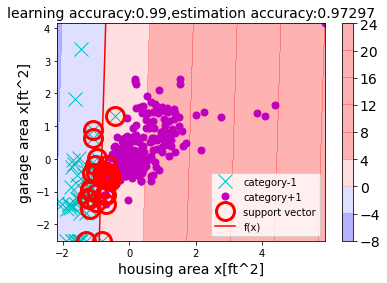

In [20]:
calculate(2, True)